https://github.com/keras-rl/keras-rl/blob/master/examples/ddpg_pendulum.py

https://keras.io/examples/rl/ddpg_pendulum/

In [1]:
import numpy as np
import gym
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#from keras.models import Sequential, Model

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Concatenate
from tensorflow.keras.optimizers import Adam

from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess
from tensorflow.python.framework import ops
ops.reset_default_graph()
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


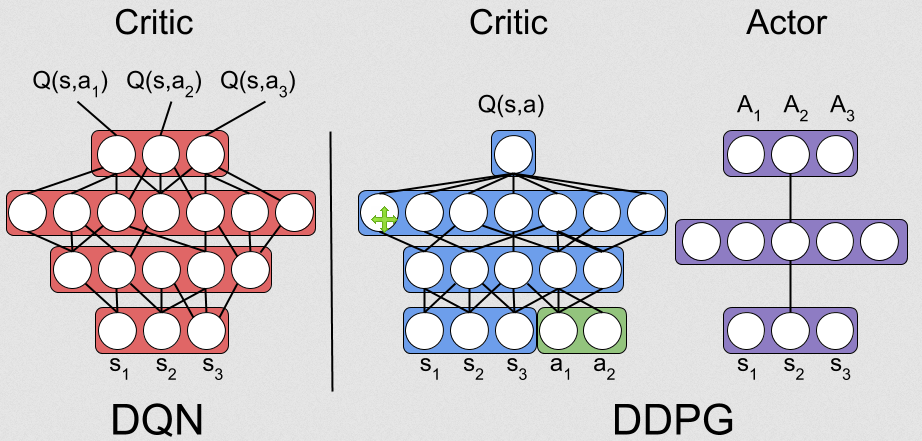
https://jmichaux.github.io/assets/week4/dqn_ddpg_cropped.png

# load environment

In [2]:



ENV_NAME = 'Pendulum-v1'


# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
assert len(env.action_space.shape) == 1
nb_actions = env.action_space.shape[0]

# Next, we build a very simple model.



# build the actor model

In [3]:
actor = tf.keras.Sequential()
actor.add(Flatten(input_shape=(1,) + env.observation_space.shape))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(nb_actions))
actor.add(Activation('linear'))
print(actor.summary())




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3)                 0         
_________________________________________________________________
dense (Dense)                (None, 16)                64        
_________________________________________________________________
activation (Activation)      (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0

# build the critic model

In [4]:
action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
flattened_observation = Flatten()(observation_input)
x = Concatenate()([action_input, flattened_observation])
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('linear')(x)
critic = Model(inputs=[action_input, observation_input], outputs=x)
print(critic.summary())



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation_input (InputLayer)  [(None, 1, 3)]       0                                            
__________________________________________________________________________________________________
action_input (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3)            0           observation_input[0][0]          
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 4)            0           action_input[0][0]               
                                                                 flatten_1[0][0]              

# compile the agent

In [5]:
# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!

memory = SequentialMemory(limit=100000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=.15, mu=0., sigma=.3)
agent = DDPGAgent(nb_actions=nb_actions, actor=actor, critic=critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=100, nb_steps_warmup_actor=100,
                  random_process=random_process, gamma=.99, target_model_update=1e-3)

In [7]:
agent.compile(Adam(lr=.001, clipnorm=1.), metrics=['mae'])

# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\hotaha\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [ ]:
agent.fit(env, nb_steps=50000, visualize=False, verbose=1, nb_max_episode_steps=200)

In [10]:
env.close()

In [8]:
# After training is done, we save the final weights.
#agent.save_weights('ddpg_weights.h5f', overwrite=True)
agent.load_weights('ddpg_weights.h5f')#.format(ENV_NAME))


# evaluate the agent

In [12]:
# Finally, evaluate our algorithm for 5 episodes.
scores=agent.test(env, nb_episodes=5, visualize=True, nb_max_episode_steps=300)
env.close()

Testing for 5 episodes ...
Episode 1: reward: -0.962, steps: 200
Episode 2: reward: -0.603, steps: 200
Episode 3: reward: -0.686, steps: 200
Episode 4: reward: -228.559, steps: 200
Episode 5: reward: -115.278, steps: 200


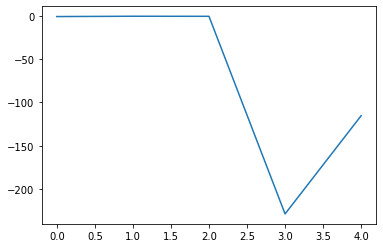

In [13]:

plt.plot(scores.history['episode_reward'])

plt.show()